In [1]:
# Loading data

# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import os
plt.style.use('ggplot')

In [15]:
# Load titanic data frame, create new columns 'dataset' then concatenate the 2 data
train = pd.read_csv('../datasets/titanic/train.csv')
test = pd.read_csv('../datasets/titanic/test.csv')

train['Dataset'] = 'train'
test['Dataset'] = 'test'

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Dataset        891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [3]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

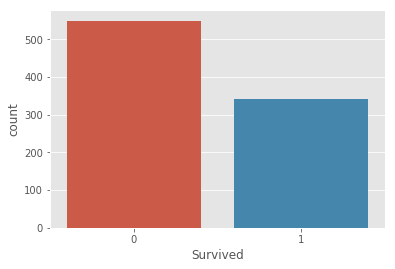

In [4]:
sns.countplot(train['Survived'])

In [5]:
train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

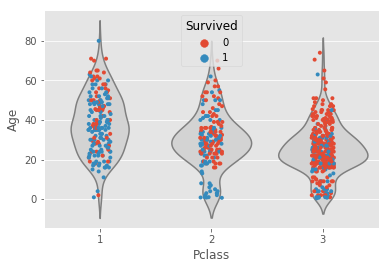

In [6]:
# Plotting Survival with age, there are many 20 plus people that did not make it, 
# as for Pclass, a lot of class 3 passenger were not able to survive the tragedy.
sns.violinplot(x = 'Pclass', y = 'Age', data = train, inner = None, color = 'lightgray')
sns.stripplot(x = 'Pclass', y = 'Age', data = train, size = 4, jitter= True, hue = 'Survived')
plt.show()

In [7]:
from passengers import passengers


def get_names_age(data):
    data['Name_Split'] = data.Name.str.split('\, ')
    data['L_Name'] = data.Name_Split.str.get(0)
    data['F_Name'] = data.Name_Split.str.get(1)
    data['F_Name'] = data.F_Name.str.split('\. ')
    data['Title'] = data.F_Name.str.get(0)
    data['F_Name'] = data.F_Name.str.get(1)
    del data['Name_Split']
    del data['L_Name']
    for x,y,z in passengers:
        data.loc[(data.Ticket == x) & (data.F_Name == y),'Age'] = z
    return data


def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Dataset        891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [9]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test


def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test


In [10]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test


def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test

In [11]:
def update_embarked(data):
    data.loc[data.Embarked.isnull(), 'Embarked'] = 'S'
    return data

def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test


def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test

In [18]:
train = get_names_age(train)
test = get_names_age(test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train = update_embarked(train)
test = update_embarked(test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett',
                                                                     'Cabin_Letter', 'Title', 'Fam_Size'])
train, test = drop(train, test)

AttributeError: 'DataFrame' object has no attribute 'Ticket'

In [19]:
train, test = drop(train, test, ['Name'])

In [21]:
train, test = drop(train, test, ['Dataset'])

In [22]:
train, test = drop(train, test, ['F_Name'])

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 43 columns):
Age                           418 non-null float64
Fare                          418 non-null float64
Age_Null_Flag                 418 non-null int64
Cabin_num_(1.999, 28.667]     418 non-null uint8
Cabin_num_(28.667, 65.667]    418 non-null uint8
Cabin_num_(65.667, 148.0]     418 non-null uint8
Ticket_Len                    418 non-null int64
Pclass_3                      418 non-null uint8
Pclass_1                      418 non-null uint8
Pclass_2                      418 non-null uint8
Sex_male                      418 non-null uint8
Sex_female                    418 non-null uint8
Embarked_S                    418 non-null uint8
Embarked_C                    418 non-null uint8
Embarked_Q                    418 non-null uint8
Ticket_Lett_A                 418 non-null uint8
Ticket_Lett_P                 418 non-null uint8
Ticket_Lett_S                 418 non-null uint8
Ticket_Le

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 44 columns):
Survived                      891 non-null int64
Age                           891 non-null float64
Fare                          891 non-null float64
Age_Null_Flag                 891 non-null int64
Cabin_num_(1.999, 28.667]     891 non-null uint8
Cabin_num_(28.667, 65.667]    891 non-null uint8
Cabin_num_(65.667, 148.0]     891 non-null uint8
Ticket_Len                    891 non-null int64
Pclass_3                      891 non-null uint8
Pclass_1                      891 non-null uint8
Pclass_2                      891 non-null uint8
Sex_male                      891 non-null uint8
Sex_female                    891 non-null uint8
Embarked_S                    891 non-null uint8
Embarked_C                    891 non-null uint8
Embarked_Q                    891 non-null uint8
Ticket_Lett_A                 891 non-null uint8
Ticket_Lett_P                 891 non-null uint8
Ticket_Le

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400,700,1000]}
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

print(gs.best_params_)
print(gs.best_score_)
print(gs.cv_results_)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.8383838383838383
{'mean_fit_time': array([0.16523941, 0.25787878, 0.79627983, 1.70842099, 2.23356231,
       0.15546163, 0.2088236 , 0.92178281, 1.55142689, 2.67790961,
       0.17935197, 0.29041942, 1.02378805, 1.59269158, 2.10433634,
       0.16118836, 0.22276831, 0.89069732, 1.50529178, 2.26427873,
       0.20875486, 0.25998163, 0.88526901, 1.51816201, 2.34232267,
       0.16057928, 0.20856937, 0.94722128, 1.72714933, 3.19508696,
       0.16247853, 0.30792991, 1.10945002, 1.62113738, 2.05619001,
       0.15556661, 0.22893373, 0.82807136, 1.64185111, 2.08587718,
       0.1614124 , 0.18752774, 0.84657208, 1.30852874, 1.90337435,
       0.16117167, 0.18675836, 0.89521488, 1.28879682, 1.94958258,
       0.1487507 , 0.17482432, 0.79906869, 1.30615306, 1.76710939,
       0.17393716, 0.18648529, 0.85094404, 1.3942492 , 1.96474926,
       0.15681203, 0.20021995, 0.84945885, 1.3220977 , 1.87712002

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=100,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8384


In [32]:
predictions = rf.predict(test)

In [35]:
test1 = pd.read_csv('../datasets/titanic/test.csv')

In [36]:
# make predictions which we will submit. 
output = pd.DataFrame({'PassengerId': test1.PassengerId,
                       'Survived': predictions})
output.to_csv('../datasets/titanic/submission_new.csv', index=False)